# Playing with model editing

In [156]:
from pathlib import Path
if Path().resolve().name == "notebooks":
    %cd ..
%ls
import sys
sys.path.append("models")
sys.path.append("data")
sys.path.append("concepts")

LICENSE                               models/
README.md                             notebook/
__pycache__/                          notebooks/
a.py                                  old_logs/
artifacts/                            pcbm_model_editing.py
assets/                               poetry.lock
combinations.jpg                      pyproject.toml
concepts/                             scripts/
configs/                              skconfig.yaml
data/                                 slurm/
debug.log                             test_cav_activation.py
debug_finakl.log                      test_different_projections.py
debug_rn18.log                        testnotebook.ipynb
docs/                                 train_pcbm.py
environment.yaml                      train_pcbm_h.py
evaluate_og_model.py                  train_pcbm_userstudy.py
experiments/                          training_tools/
extension_scripts/                    verify_clip_pcbm_h.py
learn_concepts_dataset.py         

In [157]:
from concepts import ConceptBank
import pickle
import torch
from models.pcbm_pl import PCBMClassifierTrainer, PCBMClassifierTrainerV2
from lightning import Trainer
from data.metashift import MetaShiftDataModule, PreprocessorEnum, MetaShiftDataModuleV2
from data.metashift import NNProjector
from models.clip_encoder import CLIPImageEncoder
from lightning.pytorch import seed_everything
from models.resnet import ResNet18FeatureExtractor
import matplotlib.pyplot as plt
from models.pcbm_pl import analyze_classifier
from renumics import spotlight
from copy import deepcopy
import torchmetrics
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassAccuracy

In [158]:
import logging
logging.basicConfig(level=logging.INFO)

In [159]:
# ckpt_path = Path("lightning_logs/task_1_bed_dog_cat/seed_55/version_0/checkpoints/epoch=9-step=320.ckpt") # lam 0.05
# ckpt_path = Path("lightning_logs/task_2_table_dog_cat/seed_42/version_23/checkpoints/epoch=9-step=320.ckpt") # lam 1.7
ckpt_path = Path("lightning_logs/task_1_bed_dog_cat/seed_101010/version_0/checkpoints/epoch=29-step=960.ckpt") # lam 10
concept_bank_path = Path("artifacts/outdir/broden_resnet18_imagenet1k_v1_0.1_50.pkl")
task_name = ckpt_path.parents[3].name

In [4]:
metashift = MetaShiftDataModule(
    task_name=task_name,
    projector=NNProjector(
        concept_bank_path=concept_bank_path,
        backbone=ResNet18FeatureExtractor(),
    ),
    preprocessor_name=PreprocessorEnum.RESNET18_IMAGENET_1K_V1,
    train_batch_size=16,
    test_batch_size=64
)
metashift.setup("train")
class_names = metashift.dataset["train"].info.features["label"].names
concept_names = metashift.projector.concept_names

CONCEPT BANK device cpu
Concept Bank is initialized.


In [5]:
spurious_class, source_concept, target_concept = task_name.split("_")[2:5]
spurious_class_ix = class_names.index(spurious_class)
source_concept_ix = concept_names.index(source_concept)
target_concept_ix = concept_names.index(target_concept)
print(f"{spurious_class}@{spurious_class_ix}: {source_concept}@{source_concept_ix}->{target_concept}@{target_concept_ix}")

bed@1: dog@72->cat@50


In [6]:
trained_pcbm = PCBMClassifierTrainer.load_from_checkpoint(ckpt_path)

In [7]:
trained_pcbm_pruned = PCBMClassifierTrainer.load_from_checkpoint(ckpt_path, pruned_concept_class_pairs=[(source_concept_ix, spurious_class_ix)])
# trained_pcbm_pruned_normalized = PCBMClassifierTrainer.load_from_checkpoint(ckpt_path, pruned_concept_class_pairs=[(50, 1)], normalize=True)

In [9]:
# og_model_path = "artifacts/outdir/pcbm_metashift_task_1_bed_dog_cat__resnet18_imagenet1k_v1__broden_resnet18_imagenet1k_v1_0__lam:0.002__alpha:0.99__seed:100.ckpt"
# og_model_path = "artifacts/outdir/pcbm_metashift_task_1_bed_dog_cat__resnet18_imagenet1k_v1__broden_resnet18_imagenet1k_v1_0__lam:0.05__alpha:0.99__seed:101010.ckpt"
og_model_path = "artifacts/outdir/pcbm_metashift_task_1_bed_dog_cat__resnet18_imagenet1k_v1__broden_resnet18_imagenet1k_v1_0__lam:0.0005__alpha:0.99__seed:0.ckpt"
with open(og_model_path, "rb") as f:
    og_model = torch.load(f)

og_model_pruned = deepcopy(og_model)
with torch.no_grad():
    og_model_pruned.classifier.weight[spurious_class_ix, source_concept_ix] = 0.0

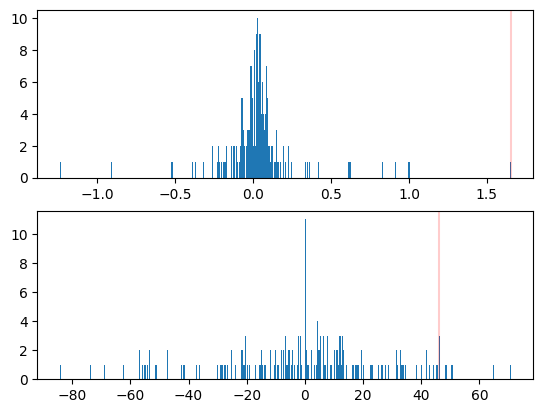

In [10]:
fig, axes = plt.subplots(2)
_ =  axes[0].hist(trained_pcbm.model.classifier.weight[spurious_class_ix].reshape(-1).cpu().detach().numpy(), bins=400)
axes[0].axvline(x=trained_pcbm.model.classifier.weight[spurious_class_ix, source_concept_ix].item(), c="r", alpha=0.2)
_ = axes[1].hist(og_model.classifier.weight[spurious_class_ix].reshape(-1).cpu().detach().numpy(), bins=400)
axes[1].axvline(x=og_model.classifier.weight[spurious_class_ix, source_concept_ix].item(), c="r", alpha=0.2)


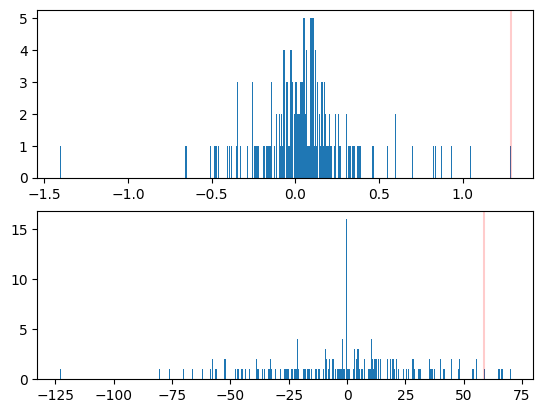

In [23]:
bad_og_model = torch.load("artifacts/outdir/pcbm_metashift_task_1_bed_dog_cat__resnet18_imagenet1k_v1__broden_resnet18_imagenet1k_v1_0__lam:0.0005__alpha:0.99__seed:4242.ckpt")
bad_trained_pcbm = PCBMClassifierTrainer.load_from_checkpoint("lightning_logs/task_1_bed_dog_cat/seed_0/version_7/checkpoints/epoch=29-step=960.ckpt")
fig, axes = plt.subplots(2)
_ =  axes[0].hist(bad_trained_pcbm.model.classifier.weight[spurious_class_ix].reshape(-1).cpu().detach().numpy(), bins=400)
axes[0].axvline(x=bad_trained_pcbm.model.classifier.weight[spurious_class_ix, source_concept_ix].item(), c="r", alpha=0.2)
_ = axes[1].hist(bad_og_model.classifier.weight[spurious_class_ix].reshape(-1).cpu().detach().numpy(), bins=400)
axes[1].axvline(x=bad_og_model.classifier.weight[spurious_class_ix, source_concept_ix].item(), c="r", alpha=0.2)

In [29]:
class_names

['airplane', 'bed', 'car', 'cow', 'keyboard']

In [31]:
bad_trained_pcbm.model.classifier.weight.shape

torch.Size([5, 170])

In [27]:
print(analyze_classifier(bad_trained_pcbm.model, class_names=class_names, concept_names=concept_names, k=10))

Class : airplane
	 1 - body: 2.614
	 2 - airplane: 1.870
	 3 - door_frame: 1.240
	 4 - mountain: 1.220
	 5 - earth: 0.746
	 6 - light: 0.719
	 7 - painted: 0.583
	 8 - sand: 0.538
	 9 - knob: 0.450
	 10 - stairs: 0.224
Class : bed
	 1 - dog: 1.287
	 2 - paw: 1.048
	 3 - armchair: 0.931
	 4 - sofa: 0.873
	 5 - cushion: 0.837
	 6 - bedclothes: 0.829
	 7 - arm: 0.696
	 8 - chest_of_drawers: 0.596
	 9 - canopy: 0.595
	 10 - bed: 0.552
Class : car
	 1 - ashcan: 0.903
	 2 - car: 0.818
	 3 - flower: 0.716
	 4 - redness: 0.570
	 5 - bus: 0.557
	 6 - base: 0.478
	 7 - palm: 0.477
	 8 - fan: 0.378
	 9 - chimney: 0.341
	 10 - column: 0.328
Class : cow
	 1 - horse: 2.698
	 2 - cow: 1.730
	 3 - clock: 1.317
	 4 - headboard: 0.927
	 5 - cup: 0.866
	 6 - jar: 0.830
	 7 - field: 0.747
	 8 - sand: 0.724
	 9 - bowl: 0.647
	 10 - mountain: 0.543
Class : keyboard
	 1 - keyboard: 2.481
	 2 - box: 1.343
	 3 - bookcase: 0.742
	 4 - figurine: 0.739
	 5 - leather: 0.553
	 6 - greenness: 0.528
	 7 - polka_dots:

In [11]:
source_concept_ix

72

In [28]:
print(analyze_classifier(trained_pcbm.model, class_names=class_names, concept_names=concept_names, k=10))

Class : airplane
	 1 - body: 2.529
	 2 - airplane: 2.158
	 3 - door_frame: 1.774
	 4 - mountain: 1.442
	 5 - painted: 0.959
	 6 - light: 0.847
	 7 - knob: 0.593
	 8 - sand: 0.459
	 9 - blueness: 0.369
	 10 - fabric: 0.355
Class : bed
	 1 - dog: 1.653
	 2 - sofa: 1.009
	 3 - paw: 1.000
	 4 - armchair: 0.912
	 5 - bedclothes: 0.836
	 6 - cushion: 0.622
	 7 - chest_of_drawers: 0.616
	 8 - canopy: 0.423
	 9 - tree: 0.360
	 10 - arm: 0.349
Class : car
	 1 - ashcan: 0.966
	 2 - car: 0.938
	 3 - base: 0.744
	 4 - bus: 0.611
	 5 - fan: 0.606
	 6 - column: 0.567
	 7 - building: 0.539
	 8 - palm: 0.492
	 9 - chimney: 0.420
	 10 - flower: 0.406
Class : cow
	 1 - horse: 2.166
	 2 - headboard: 1.485
	 3 - cow: 1.415
	 4 - cup: 1.300
	 5 - napkin: 1.000
	 6 - clock: 0.982
	 7 - pillow: 0.818
	 8 - sand: 0.706
	 9 - bag: 0.666
	 10 - field: 0.660
Class : keyboard
	 1 - keyboard: 2.793
	 2 - box: 0.753
	 3 - figurine: 0.615
	 4 - bookcase: 0.595
	 5 - polka_dots: 0.414
	 6 - leather: 0.395
	 7 - cat: 

In [19]:
print(trained_pcbm_pruned.model.classifier.weight[spurious_class_ix, source_concept_ix])
print(analyze_classifier(trained_pcbm_pruned.model, class_names=class_names, concept_names=concept_names))

tensor(0., device='mps:0', grad_fn=<SelectBackward0>)
Class : airplane
	 1 - body: 2.529
	 2 - airplane: 2.158
	 3 - door_frame: 1.774
	 4 - mountain: 1.442
	 5 - painted: 0.959
Class : bed
	 1 - sofa: 1.009
	 2 - paw: 1.000
	 3 - armchair: 0.912
	 4 - bedclothes: 0.836
	 5 - cushion: 0.622
Class : car
	 1 - ashcan: 0.966
	 2 - car: 0.938
	 3 - base: 0.744
	 4 - bus: 0.611
	 5 - fan: 0.606
Class : cow
	 1 - horse: 2.166
	 2 - headboard: 1.485
	 3 - cow: 1.415
	 4 - cup: 1.300
	 5 - napkin: 1.000
Class : keyboard
	 1 - keyboard: 2.793
	 2 - box: 0.753
	 3 - figurine: 0.615
	 4 - bookcase: 0.595
	 5 - polka_dots: 0.414


In [16]:
print(og_model.analyze_classifier())

Class : airplane
	 1 - countertop: 73.416
	 2 - jar: 63.339
	 3 - paper: 56.068
	 4 - pillow: 53.166
	 5 - fireplace: 50.551
Class : bed
	 1 - awning: 70.813
	 2 - building: 64.902
	 3 - blackness: 50.810
	 4 - bicycle: 50.386
	 5 - street_s: 48.355
Class : car
	 1 - desk: 73.613
	 2 - refrigerator: 71.373
	 3 - carpet: 70.873
	 4 - cat: 68.150
	 5 - neck: 62.685
Class : cow
	 1 - person: 76.686
	 2 - pipe: 52.420
	 3 - base: 50.049
	 4 - blueness: 49.875
	 5 - car: 49.821
Class : keyboard
	 1 - chain_wheel: 102.402
	 2 - sofa: 80.470
	 3 - outside_arm: 77.477
	 4 - exhaust_hood: 76.530
	 5 - balcony: 72.173


In [ ]:
import dataset

In [17]:
print(og_model_pruned.analyze_classifier())

Class : airplane
	 1 - countertop: 73.416
	 2 - jar: 63.339
	 3 - paper: 56.068
	 4 - pillow: 53.166
	 5 - fireplace: 50.551
Class : bed
	 1 - awning: 70.813
	 2 - building: 64.902
	 3 - blackness: 50.810
	 4 - bicycle: 50.386
	 5 - street_s: 48.355
Class : car
	 1 - desk: 73.613
	 2 - refrigerator: 71.373
	 3 - carpet: 70.873
	 4 - cat: 68.150
	 5 - neck: 62.685
Class : cow
	 1 - person: 76.686
	 2 - pipe: 52.420
	 3 - base: 50.049
	 4 - blueness: 49.875
	 5 - car: 49.821
Class : keyboard
	 1 - chain_wheel: 102.402
	 2 - sofa: 80.470
	 3 - outside_arm: 77.477
	 4 - exhaust_hood: 76.530
	 5 - balcony: 72.173


In [4]:
import datasets
ds = datasets.load_dataset("anonymous347928/pcbm_metashift", name=task_name)
spotlight.show(ds["train"])
spotlight.show(ds["test"])

ModuleNotFoundError: No module named 'datasets'

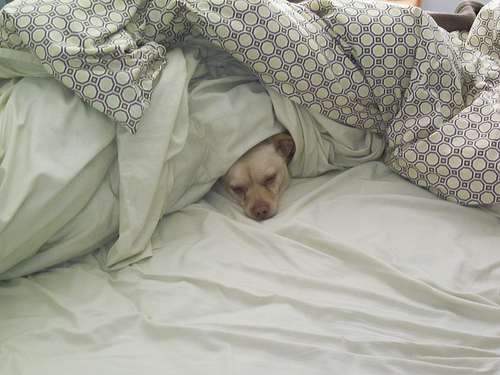

In [180]:
ds["train"][118]["image"]

In [46]:
x = og_model.classifier.weight[4].detach().cpu().reshape(-1).numpy().tolist()
a = dict(list(sorted(zip(concept_names, x), key=lambda item: item[1], reverse=True)))

In [42]:
og_model.classifier.weight[spurious_class_ix, source_concept_ix]

tensor(0., device='mps:0', grad_fn=<SelectBackward0>)

In [39]:
from torchmetrics.functional.classification import multiclass_precision, multiclass_recall

tensor(0.9060)
pre_base tensor(0.9124)
rec_base tensor(0.9060)
tensor(0.9120)
pre_pruned tensor(0.9168)
rec_pruned tensor(0.9120)
tensor(0.2300)
pre_og tensor(0.1874)
rec_og tensor(0.2300)
tensor(0.2240)
pre_ogpruned tensor(0.1832)
rec_ogpruned tensor(0.2240)


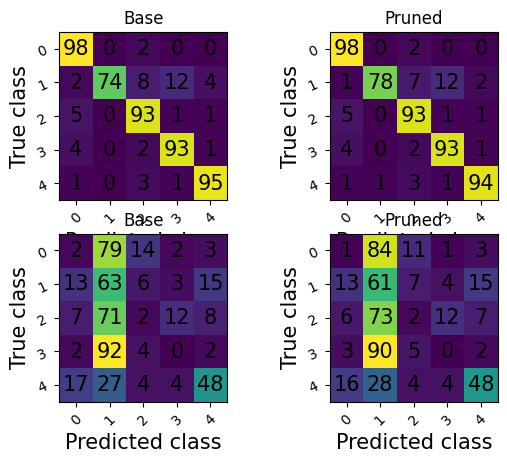

In [48]:
# with torch.no_grad():
#     trained_pcbm_pruned.model.classifier.weight[1, 50] = 0.
#     trained_pcbm_pruned_normalized.model.classifier.weight[1, 50] = 0.
# with torch.no_grad():
#      trained_pcbm.model.classifier.weight = og_model.classifier.weight
#      trained_pcbm_pruned.model.classifier.weight = og_model.classifier.weight
#      trained_pcbm_pruned.model.classifier.weight[4, 72] = 0.0
#     trained_pcbm_pruned_normalized.model.classifier.weight = og_model.classifier.weight
from torchvision import transforms
with torch.no_grad():
    trained_pcbm.to("cpu")
    trained_pcbm_pruned.to("cpu")
    og_model.to("cpu")
    og_model_pruned.to("cpu")
    # trained_pcbm_pruned_normalized.to("cpu")
    base_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
    pruned_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
    base_acc = MulticlassAccuracy(num_classes=5)
    pruned_acc = MulticlassAccuracy(num_classes=5)

    base_og_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
    pruned_og_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
    base_og_acc = MulticlassAccuracy(num_classes=5)
    pruned_og_acc = MulticlassAccuracy(num_classes=5)
    # norm_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")

    batch = metashift.dataset["train"]
    inputs = batch["input"]
    targets = batch["label"]

    base_preds = trained_pcbm(batch)
    base_cm(base_preds, targets)
    print(base_acc(base_preds, targets))
    print("pre_base", multiclass_precision(base_preds, targets, num_classes=5, average="macro"))
    print("rec_base", multiclass_recall(base_preds, targets, num_classes=5, average="macro"))

    pruned_preds = trained_pcbm_pruned(batch)
    pruned_cm(pruned_preds, targets)
    print(pruned_acc(pruned_preds, targets))
    print("pre_pruned", multiclass_precision(pruned_preds, targets, num_classes=5, average="macro"))
    print("rec_pruned", multiclass_recall(pruned_preds, targets, num_classes=5, average="macro"))

    base_og_preds = og_model.classifier(inputs)
    base_og_cm(base_og_preds, targets)
    print(base_og_acc(base_og_preds, targets))
    print("pre_og", multiclass_precision(base_og_preds, targets, num_classes=5, average="macro"))
    print("rec_og", multiclass_recall(base_og_preds, targets, num_classes=5, average="macro"))

    pruned_og_preds = og_model_pruned.classifier(inputs)
    pruned_og_cm(pruned_og_preds, targets)
    print(pruned_og_acc(pruned_og_preds, targets))
    print("pre_ogpruned", multiclass_precision(pruned_og_preds, targets, num_classes=5, average="macro"))
    print("rec_ogpruned", multiclass_recall(pruned_og_preds, targets, num_classes=5, average="macro"))

fig, axes = plt.subplots(2, 2,)# figsize=(12, 8))
base_cm.plot(ax=axes[0][0])
axes[0][0].title.set_text("Base")
pruned_cm.plot(ax=axes[0][1])
axes[0][1].title.set_text("Pruned")

base_og_cm.plot(ax=axes[1][0])
axes[1][0].title.set_text("Base")
pruned_og_cm.plot(ax=axes[1][1])
axes[1][1].title.set_text("Pruned")

plt.show()


In [50]:
base_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
base

In [66]:
base_cm.update(base_preds, targets)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

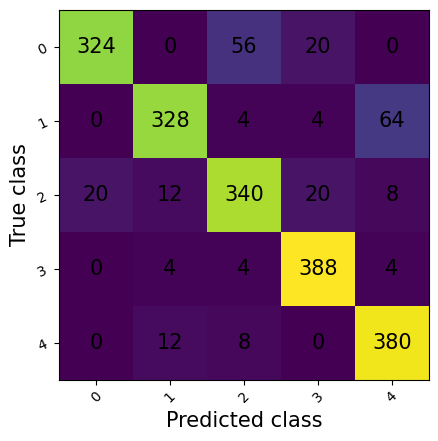

In [67]:
base_cm.plot()

In [58]:
base_cm.reset()

In [191]:
print(base_preds[2])
print(pruned_preds[2])

tensor([ -96.3905, -206.2929,   98.1887, -141.7721,   -7.0952])
tensor([ -96.3905, -206.2929,   98.1887, -141.7721,   -7.0952])


In [86]:
class_names

['airplane', 'bed', 'car', 'cow', 'keyboard']

In [21]:
trainer = Trainer(deterministic=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
SEED = 55

In [3]:
seed_everything(SEED)
trainer.test(trained_pcbm, metashift)

NameError: name 'seed_everything' is not defined

In [8]:
pcbm_trainer = PCBMClassifierTrainer(n_concepts=170, n_classes=5, lr=0.05, lam=0.05, alpha=0.99)


In [10]:
seed_everything(42)
trainer = Trainer(deterministic=True, max_epochs=30)

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
seed = 100

In [61]:
seed_everything(seed)
trainer.fit(pcbm_trainer, metashift)

Seed set to 100

  | Name  | Type           | Params
-----------------------------------------
0 | model | PCBMClassifier | 855   
1 | loss  | PCBMLoss       | 855   
-----------------------------------------
855       Trainable params
0         Non-trainable params
855       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [1]:
seed_everything(seed)
out = trainer.test(pcbm_trainer, metashift)

NameError: name 'seed_everything' is not defined

In [63]:
print(out)

[{'test_accuracy': 0.8939999938011169}]


In [2]:
trainer.checkpoint_callback.best_model_path

NameError: name 'trainer' is not defined

In [65]:
pcbm_trainer_pruned = PCBMClassifierTrainer.load_from_checkpoint(trainer.checkpoint_callback.best_model_path,
                                                          pruned_concept_class_pairs=[(128, 1)]
                                                         )

In [66]:
pcbm_trainer_pruned.model.classifier.weight[1, 128]

tensor(0., device='mps:0', grad_fn=<SelectBackward0>)

In [67]:
pcbm_trainer.model.classifier.weight[1, 128]

tensor(1.2930, grad_fn=<SelectBackward0>)

In [68]:
seed_everything(seed)
pruned_out = trainer.test(pcbm_trainer_pruned, metashift)

Seed set to 100


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8980000019073486     │
└───────────────────────────┴───────────────────────────┘

In [16]:
path = Path("lightning_logs/task_1_bed_dog_cat/seed_42/version_6/checkpoints/epoch=19-step=640.ckpt")
print(path)
pcbm = PCBMClassifierTrainer.load_from_checkpoint(str(path))

lightning_logs/task_1_bed_dog_cat/seed_42/version_6/checkpoints/epoch=19-step=640.ckpt


In [4]:
from models.resnet import ResNet18FeatureExtractor

In [8]:
CONCEPT_BANK = "artifacts/outdir/broden_resnet18_imagenet1k_v1_0.1_50.pkl"
all_concepts = pickle.load(open(CONCEPT_BANK, 'rb'))
all_concept_names = list(all_concepts.keys())
concept_bank = ConceptBank(all_concepts, args.device)

Concept Bank is initialized.


In [11]:
metashift_resnet18 = MetaShiftDataModule(
    task_name="task_1_bed_dog_cat",
    projector=NNProjector(
        concept_bank_path="artifacts/outdir/broden_resnet18_imagenet1k_v1_0.1_50.pkl",
        backbone=ResNet18FeatureExtractor(),
    ),
    preprocessor_name=PreprocessorEnum.RESNET18_IMAGENET_1K_V1,
    train_batch_size=16,
    test_batch_size=64
)
metashift_resnet18.setup("test")

Concept Bank is initialized.


In [12]:
metashift_resnet50 = MetaShiftDataModule(
    task_name="task_1_bed_dog_cat",
    projector=NNProjector(
        concept_bank_path="artifacts/outdir/broden_clip_RN50_10.0_50.pkl",
        backbone=CLIPImageEncoder(model_name="RN50"),
    ),
    preprocessor_name=PreprocessorEnum.CLIP_RESNET50,
    train_batch_size=16,
    test_batch_size=64
)
metashift_resnet50.setup("test")

Concept Bank is initialized.


In [8]:
import pickle
with open("artifacts/outdir/broden_clip_RN50_10.0_50.pkl", "rb") as f:
    concept_dict = pickle.load(f)

dict

In [14]:
cons = ["cat", "dog", "book"]
for con in cons:
    print(metashift_resnet18.projector.concept_names.index(con))

50
72
30


In [15]:
for con in cons:
    print(metashift_resnet50.projector.concept_names.index(con))

50
72
30


In [18]:
pcbm.model.classifier.weight[1, 72]

tensor(-0.3531, device='mps:0', grad_fn=<SelectBackward0>)

In [17]:
s =analyze_classifier(
    pcbm.model,
    concept_names=metashift_resnet18.projector.concept_names,
    class_names=metashift_resnet18.dataset["train"].info.features["label"].names,
)
print(s)

Class : airplane
	 1 - jar: 2.947
	 2 - pillow: 1.865
	 3 - ceramic: 1.854
	 4 - hair: 1.734
	 5 - paper: 1.538
Class : bed
	 1 - mouse: 2.838
	 2 - clock: 2.642
	 3 - bus: 2.136
	 4 - balcony: 1.924
	 5 - bicycle: 1.461
Class : car
	 1 - handle: 1.552
	 2 - chandelier: 1.310
	 3 - headlight: 1.309
	 4 - bench: 1.294
	 5 - fireplace: 1.251
Class : cow
	 1 - redness: 1.824
	 2 - field: 1.820
	 3 - bird: 1.780
	 4 - bedclothes: 1.732
	 5 - minibike: 1.701
Class : keyboard
	 1 - sofa: 2.877
	 2 - laminate: 2.399
	 3 - bicycle: 2.219
	 4 - blotchy: 1.948
	 5 - air_conditioner: 1.788


In [10]:
concept_bank.concept_info.concept_names

['cat',
 'paper',
 'apron',
 'microwave',
 'tree',
 'pane',
 'lamp',
 'polka_dots',
 'flowerpot',
 'fluorescent',
 'hand',
 'drawer',
 'fireplace',
 'figurine',
 'blind',
 'bench',
 'basket',
 'footboard',
 'chandelier',
 'handle_bar',
 'flag',
 'bedclothes',
 'drinking_glass',
 'car',
 'chain_wheel',
 'can',
 'balcony',
 'eye',
 'bed',
 'pipe',
 'box',
 'cup',
 'manhole',
 'granite',
 'desk',
 'back',
 'greenness',
 'cushion',
 'ceramic',
 'water',
 'dog',
 'plant',
 'board',
 'handle',
 'metal',
 'foot',
 'concrete',
 'armchair',
 'curtain',
 'ground',
 'person',
 'pedestal',
 'grass',
 'stripes',
 'flower',
 'bridge',
 'ottoman',
 'blotchy',
 'redness',
 'coffee_table',
 'path',
 'cardboard',
 'cabinet',
 'laminate',
 'jar',
 'body',
 'outside_arm',
 'oven',
 'pack',
 'chair',
 'exhaust_hood',
 'napkin',
 'paw',
 'bus',
 'chest_of_drawers',
 'hill',
 'plate',
 'frame',
 'nose',
 'mouth',
 'column',
 'doorframe',
 'headlight',
 'loudspeaker',
 'motorbike',
 'inside_arm',
 'pillar',
 

In [ ]:
analyze_classifier(pcbm.model, class_names=)

In [ ]:
cktp_path ="lightning_logs/task_1_bed_cat_dog/seed_55/version_0/checkpoints/epoch=320.ckpt"


In [73]:
import datasets
ds = datasets.load_from_disk(".cache/anonymous347928/pcbm_metashift/task_1_bed_cat_dog/RESNET18_IMAGENET_1K_V1")

In [78]:
layout= spotlight.layouts.debug_classification(label='label', embedding='embedding')
spotlight.show(ds["train"], layout=layout)

In [79]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'embedding'],
        num_rows: 500
    })
    test: Dataset({
        features: ['label', 'embedding'],
        num_rows: 500
    })
})

In [75]:
spotlight.show(ds["test"])

In [19]:
from data.metashift import BackboneEnum
metashift_v2 = MetaShiftDataModuleV2(
    task_name=task_name,
    backbone_name=BackboneEnum.RESNET18_IMAGENET_1K_V1,
    train_batch_size=16,
    test_batch_size=64
)
metashift_v2.setup("train")
class_names = metashift_v2.dataset["train"].info.features["label"].names

INFO:root:Attempting to load fact-40/pcbm_metashift/task_1_bed_dog_cat from cache .cache/fact-40/pcbm_metashift/task_1_bed_dog_cat/RESNET18_IMAGENET_1K_V1
INFO:root:Loaded fact-40/pcbm_metashift/task_1_bed_dog_cat from cache .cache/fact-40/pcbm_metashift/task_1_bed_dog_cat/RESNET18_IMAGENET_1K_V1


In [11]:
pcbm_v2 = PCBMClassifierTrainerV2(n_concepts=170, n_classes=5, lr=0.05, lam=85, alpha=0.99, concept_bank_path=concept_bank_path)

CONCEPT BANK device None
Concept Bank is initialized.


In [24]:
print(torch.allclose(metashift.projector.cb_vectors, pcbm_v2.model.concept_bank.vectors))
print(torch.allclose(metashift.projector.cb_intercepts, pcbm_v2.model.concept_bank.intercepts))
print(torch.allclose(metashift.projector.cb_norms, pcbm_v2.model.concept_bank.norms))

True
True
True


In [53]:
def prune_and_normalize(a: torch.Tensor, ix: int):
    b = a.clone()
    b[ix] = 0
    pruned_norm = a[ix]
    unpruned_norm = a.abs().sum()
    scaling_factor = pruned_norm / unpruned_norm
    return b * (1 + scaling_factor)

In [142]:
def normalized_prune(a: torch.Tensor, zeroed_indices: list[int]):
    """ 
    Given tensor a and list of `zeroed_indices`, return tensor b 
    such that b[i] = 0 for all `i` in `zeroed_indices` and
    the l1 norm of b is the same as the l1 norm of a.
    """
    with torch.no_grad():
        b = a.clone()
        b[zeroed_indices] = 0.0

        # TODO: re-scale b's weights such that its l1 norm is the same as a's l1 norm.
        l1_norm_a = torch.norm(a, p=1)
        l1_norm_b = torch.norm(b, p=1)

        if l1_norm_a != 0:
            scaling_factor = l1_norm_a / l1_norm_b
            b *= scaling_factor
        return b

In [145]:
a = torch.Tensor([-1., -10, -3, 2])

In [151]:
b = prune_and_normalize(a, 1)
c = normalized_prune(a, [1])
print(a)
print(a.abs().sum())
print(b.abs().sum())
print(c.abs().sum())
print(torch.allclose(a.abs().sum(), c.abs().sum()))

tensor([ -1., -10.,  -3.,   2.])
tensor(16.)
tensor(2.2500)
tensor(16.)
True


In [181]:
import pandas as pd

In [205]:
df = pd.read_csv("logs/base_clip_resnet50/42-12-23-34-45-56-67-78-89-100/lam_17/metrics.csv")

In [206]:
[col for col in df.columns if col.endswith("accuracy")]

['base_accuracy',
 'base_spurious_class_accuracy',
 'pruned_accuracy',
 'pruned_spurious_class_accuracy',
 'pruned_normalize_accuracy',
 'pruned_normalize_spurious_class_accuracy',
 'finetuned_accuracy',
 'finetuned_spurious_class_accuracy']

In [209]:
df.groupby("task_name").mean().mean().round(4)[["base_accuracy", "pruned_accuracy", "pruned_normalize_accuracy", "finetuned_accuracy"]]

base_accuracy                0.8637
pruned_accuracy              0.8639
pruned_normalize_accuracy    0.8638
finetuned_accuracy           0.9679
dtype: float64

In [210]:
df.groupby("task_name").mean().sem().round(4)[["base_accuracy", "pruned_accuracy", "pruned_normalize_accuracy", "finetuned_accuracy"]]

base_accuracy                0.0204
pruned_accuracy              0.0197
pruned_normalize_accuracy    0.0198
finetuned_accuracy           0.0054
dtype: float64

In [211]:
df = pd.read_csv("logs/base_clip_resnet50/42-12-23-34-45-56-67-78-89-100/lam_17/metrics_gain.csv")

In [212]:
[col for col in df.columns if col.endswith("accuracy_gain")]

['pruned_accuracy_gain',
 'pruned_spurious_class_accuracy_gain',
 'pruned_normalize_accuracy_gain',
 'pruned_normalize_spurious_class_accuracy_gain',
 'finetuned_accuracy_gain',
 'finetuned_spurious_class_accuracy_gain']

In [214]:
df.groupby("task_name").mean().mean().round(4)[["pruned_accuracy_gain", "pruned_normalize_accuracy_gain", "finetuned_accuracy_gain"]]

pruned_accuracy_gain              0.0002
pruned_normalize_accuracy_gain    0.0001
finetuned_accuracy_gain           0.1042
dtype: float64

In [188]:
df.groupby("task_name").mean().sem().round(3)[["pruned_accuracy_gain", "pruned_normalize_accuracy_gain", "finetuned_accuracy_gain"]]

pruned_accuracy_gain              0.001
pruned_normalize_accuracy_gain    0.001
finetuned_accuracy_gain           0.017
dtype: float64

In [133]:
df.groupby("task_name").sem().round(3)["finetuned_accuracy"]

task_name
task_1_bed_cat_dog        0.001
task_1_bed_dog_cat        0.004
task_2_table_books_cat    0.001
task_2_table_books_dog    0.002
task_2_table_cat_dog      0.002
task_2_table_dog_cat      0.002
Name: finetuned_accuracy, dtype: float64

In [102]:
# base_path = Path("logs/base_resnet18_imagenet1k_v1/42-12-23-34-45-56-67-78-89-100")
base_path = Path("logs/base_clip_resnet50/42-12-23-34-45-56-67-78-89-100")
lams = [1.7, 42.5, 85]
paths = [base_path / f"lam_{lam}" for lam in [17, 425, 85]]
columns = "pruned_accuracy_gain,pruned_precision_gain,pruned_recall_gain,pruned_spurious_class_precision_gain,pruned_spurious_class_recall_gain,pruned_spurious_class_accuracy_gain,pruned_normalize_accuracy_gain,pruned_normalize_precision_gain,pruned_normalize_recall_gain,pruned_normalize_spurious_class_precision_gain,pruned_normalize_spurious_class_recall_gain,pruned_normalize_spurious_class_accuracy_gain,finetuned_accuracy_gain,finetuned_precision_gain,finetuned_recall_gain,finetuned_spurious_class_precision_gain,finetuned_spurious_class_recall_gain,finetuned_spurious_class_accuracy_gain"

dfs = []
for lam, lam_path in zip(lams, paths):
    df = pd.read_csv(lam_path / "aggregated_metrics_gain.csv")
    df["lam"] = lam
    dfs.append(df)

df = pd.concat(dfs)


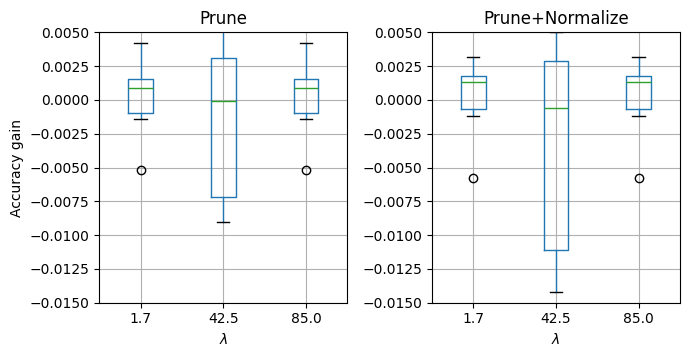

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
df.boxplot("pruned_accuracy_gain", "lam", ax = axes[0])
df.boxplot("pruned_normalize_accuracy_gain", "lam", ax = axes[1])
axes[0].set_ylim(-0.015, 0.005)
axes[1].set_ylim(-0.015, 0.005)
axes[0].title.set_text("Prune")
axes[0].set_ylabel("Accuracy gain")
axes[0].set_xlabel("$\lambda$")
axes[1].set_xlabel("$\lambda$")
axes[1].title.set_text("Prune+Normalize")
fig.tight_layout()
fig.suptitle("")
fig.savefig("combinations.jpg", dpi=900)

In [ ]:
df = pd.read_csv("logs/base_resnet18_imagenet1k_v1/42-12-23-34-45-56-67-78-89-100/lam_17/metrics.csv")